# Comparaison des distances inter-distributions
Dans ce notebook on compare selon plusieurs critères les performances entre plusieurs distances (KLD, MMD-RBF, MMD_IRQ)

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def KLD(var, mu):
    return .5 * (var - 1 + mu**2 - np.log(var))

In [96]:
mu = np.linspace(0,10,6).reshape(1,6)
var = np.linspace(.1,15,1000).reshape(1000,1)

In [97]:
def KL_bench(var,mu):
    KL_bench = KLD(var,mu)
    plt.plot(var,KL_bench)
    plt.xlabel("var")
    plt.ylabel("KLD")

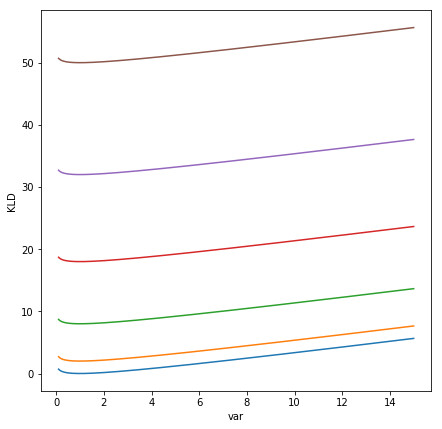

In [99]:
plt.figure(figsize=(7,7))
KL_bench(var,mu)